In [43]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile 

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [44]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt

In [45]:
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [46]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [47]:
# For testing: print URL of desired variable, paste into browser, and open downloaded data file
#pm25['url']
#pm10['url']
#wspd['url']
#rhum['url']
temp['url']

'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/D14/Met/TEMP//horario_000.ic&from=031215&to=220124&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

In [48]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Non-ideal way of dealing with column numbers in PM data vs. weather data
    data = [ line+' ,' for line in data ]
    # Keep lines with date; time; and validated, preliminary, or non-validated data (latter two are only in PM datasets)
    data = [ line.split(',')[0:5] for line in data if \
             isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) or isfloat(line.split(',')[4]) ]
    return data

In [49]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary', 'non-validated'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    # Combine validated, preliminary, and non-validated data columns
    df[series['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
    df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [50]:
print(df_tot.tail(n=15))

                  datetime  pm2.5  pm10     rhum     temp      wspd     wdir
158199 2022-01-23 22:00:00    7.0  38.0  45.8333  20.9667  0.875767  127.508
158200 2022-01-23 23:00:00    8.0  50.0  50.1667  19.3667  0.511942  148.910
158201 2022-01-24 00:00:00   11.0  50.0  55.8333  17.8583  0.126140  190.769
158202 2022-01-24 01:00:00   16.0  45.0  56.7500  17.0250  0.133638  180.042
158203 2022-01-24 02:00:00   13.0  45.0  57.8333  16.6333  0.660148  195.301
158204 2022-01-24 03:00:00    9.0  30.0  59.4167  15.8583  0.102572  114.928
158205 2022-01-24 04:00:00    7.0  31.0  65.4167  14.6083  0.000000   90.000
158206 2022-01-24 05:00:00   10.0  31.0  68.6667  13.8583  0.000000   90.000
158207 2022-01-24 06:00:00   20.0  59.0  67.0833  15.0583  0.047196  164.396
158208 2022-01-24 07:00:00   18.0  83.0  47.1667  20.4750  0.368778  252.489
158209 2022-01-24 08:00:00   15.0  65.0  37.1667  22.5167  1.243450  247.184
158210 2022-01-24 09:00:00   11.0  69.0  31.9167  25.1167  0.601187  209.597

In [51]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

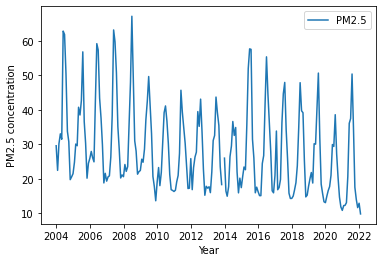

In [56]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
t_min='2000-01-01'
t_max='2030-01-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('M').mean(),'-', label='PM2.5')
#plt.plot(df_tot['pm10'][t_min:t_max].resample('M').mean(),'-', label='PM10')
#plt.plot(df_tot['temp'][t_min:t_max].resample('M').mean(),'-', label='humidity')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration')
plt.legend()

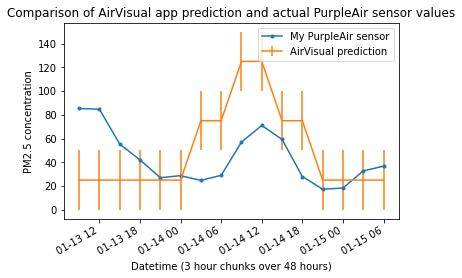

The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.


In [57]:
# Test of AirVisual prediction vs. the actual reading of my sensor

airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start='2022-01-13 09:00:00', end='2022-01-15 06:00:00', periods=16)

fig, ax = plt.subplots()
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
#ax.plot(dates,sensor, 'b.')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction')
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('PM2.5 concentration')
ax.legend()
plt.show()

print('The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.')

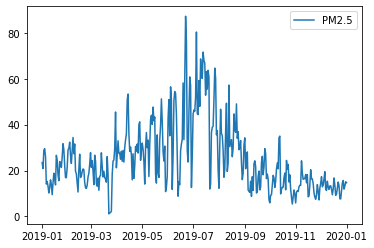

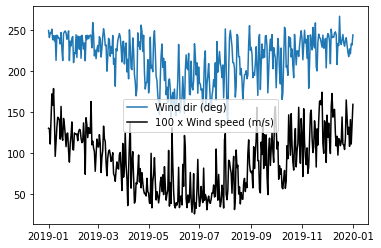

In [58]:
# Sample plots
# Top: resampled (daily) PM2.5 concentration as a function of time in 2019 (pre-pandemic year)
# Bottom: resampled (daily) wind direction (deg) and wind speed (m/s, rescaled by 100x) with the same time range
##### THERE ARE CLEAR CORRELATIONS BETWEEN PM2.5 CONCENTRATION AND BOTH WIND DIRECTION AND WIND SPEED.  
##### IN THE WINTER THE WIND DIES DOWN, AND THUS THE POLLUTION IS NOT BLOWN AWAY.
##### THE CHANGE IN WIND DIRECTION FROM THE WEST=270 DEG IN THE SUMMER VS. THE SOUTH=180 DEG IN THE WINTER
#####    DESERVES FURTHER EXPLORATION.

t_min='2019-01-01'
t_max='2020-01-01'
plt.figure()
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('D').mean(),'-', label='PM2.5')
plt.legend()
plt.figure()
plt.plot(df_tot['wdir'][t_min:t_max].resample('D').mean(),'-', label='Wind dir (deg)')
plt.plot(100*df_tot['wspd'][t_min:t_max].resample('D').mean(),'k-', label='100 x Wind speed (m/s)')
plt.legend()

In [55]:
# TO DO: 
# Do PCA on the time series and remove the annual and diurnal signals
# Test correlations: positive (PM2.5 and PM10), and negative (temp and rhum)
# Train model using all of the Santiago data vs. just some of it (e.g., removing wspd and wdir) to see which variables provide better predictive power
